In [ ]:
pip install tensorflow scikit-learn scipy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


Training data samples: 5365
Validation data samples: 596
Test data samples: 663
Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 265s 6s/step - accuracy: 0.6226 - loss: 0.7649 - val_accuracy: 0.6510 - val_loss: 0.6671
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 232s 6s/step - accuracy: 0.7198 - loss: 0.5461 - val_accuracy: 0.3490 - val_loss: 0.7594
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 232s 6s/step - accuracy: 0.7375 - loss: 0.5030 - val_accuracy: 0.3490 - val_loss: 0.8369
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 233s 6s/step - accuracy: 0.7528 - loss: 0.4854 - val_accuracy: 0.3490 - val_loss: 1.1832
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 232s 6s/step - accuracy: 0.7617 - loss: 0.4747 - val_accuracy: 0.3490 - val_loss: 1.0228
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 233s 6s/step - accuracy: 0.7911 - loss: 0.4243 - val_accuracy: 0.3591 - val_loss: 0.9221
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 235s 6s/step - accuracy: 0.7959 - loss: 0.4265 - val_accuracy: 0.3943 - val_loss: 0.8184
Epoch 8/30
42/42 ━━━━━━━━━━━━━━

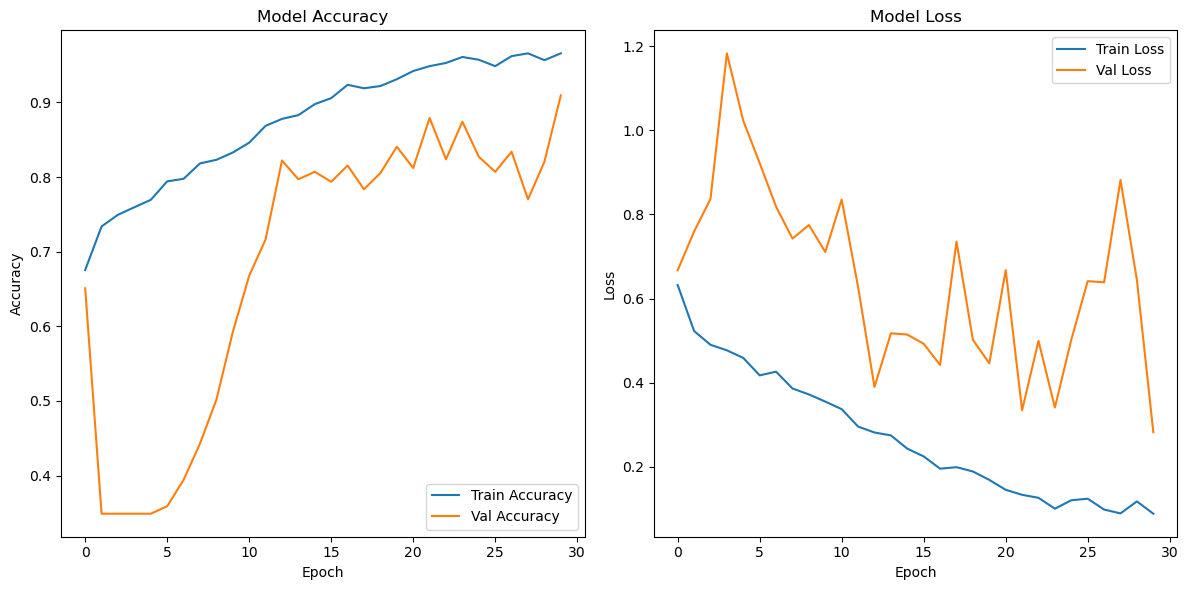

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step


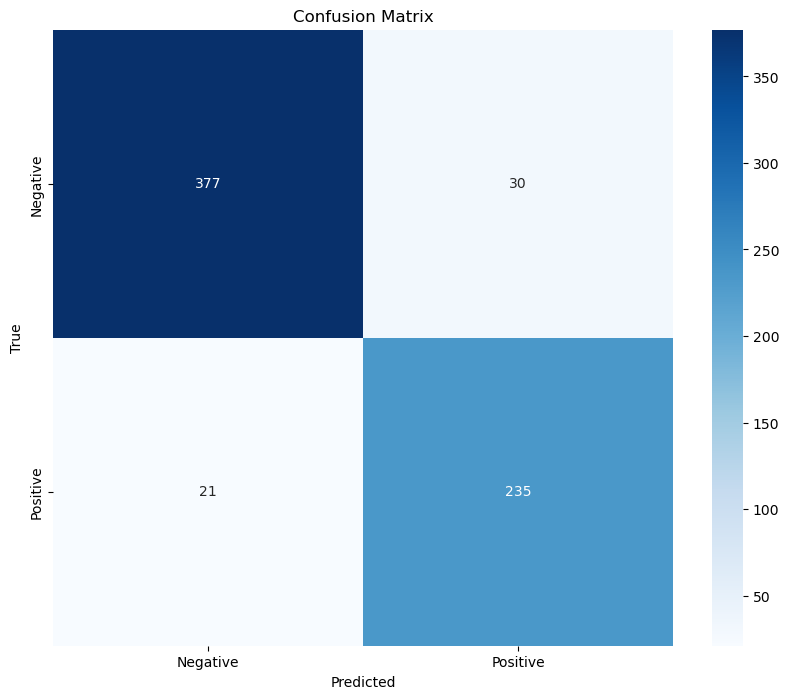

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
Classification Report:
               precision    recall  f1-score   support

    Negative       0.95      0.93      0.94       407
    Positive       0.89      0.92      0.90       256

    accuracy                           0.92       663
   macro avg       0.92      0.92      0.92       663
weighted avg       0.92      0.92      0.92       663



In [ ]:
#median+marho+convmixer
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from scipy.ndimage import median_filter
from skimage.morphology import dilation, erosion, disk
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define the dataset directory
dataset_dir = r"D:\MuTTu\Rajeev"

# Initialize lists to hold the images and labels
images = []
labels = []

# Apply median filter and morphological operations on each channel
def apply_preprocessing(image, filter_size=3, morph_radius=1):
    # Apply median filter
    filtered = median_filter(image, size=filter_size)

    # Create a morphological structuring element
    selem = disk(morph_radius)

    # If image has 3 channels (RGB), process each channel separately
    if len(filtered.shape) == 3:  # (height, width, channels)
        processed_channels = []
        for i in range(filtered.shape[-1]):
            channel = filtered[..., i]  # Extract channel
            # Apply morphological operations: dilation followed by erosion
            dilated = dilation(channel, selem)
            eroded = erosion(dilated, selem)
            processed_channels.append(eroded)

        # Stack the processed channels back into an image
        processed_image = np.stack(processed_channels, axis=-1)
    else:
        # If the image is grayscale, apply operations directly
        dilated = dilation(filtered, selem)
        processed_image = erosion(dilated, selem)

    return processed_image

# Load images and labels
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if file_name.endswith(('.png', '.jpg', '.jpeg')):
                image = load_img(file_path, target_size=(32, 32))
                image = img_to_array(image)
                image = apply_preprocessing(image)  # Apply preprocessing
                images.append(image)
                labels.append(class_name)

# Convert lists to numpy arrays
x_data = np.array(images)
y_data = np.array(labels)

# Encode class labels
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(y_data)

# Split the data into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.1, random_state=42
)
val_split = 0.1
val_indices = int(len(x_train) * val_split)
x_val, y_val = x_train[:val_indices], y_train[:val_indices]
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

image_size = 32
batch_size = 128
auto = tf.data.AUTOTUNE

# Data augmentation
augmentation_layers = [
    layers.RandomCrop(image_size, image_size),
    layers.RandomFlip("horizontal"),
]

def augment_images(images):
    for layer in augmentation_layers:
        images = layer(images, training=True)
    return images

def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(lambda x, y: (augment_images(x), y), num_parallel_calls=auto)
    return dataset.prefetch(auto)

train_dataset = make_datasets(new_x_train, new_y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

# ConvMixer model blocks
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)

def conv_stem(x, filters, patch_size):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)

def conv_mixer_block(x, filters, kernel_size):
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])
    x = layers.Conv2D(filters, kernel_size=1)(x)
    return activation_block(x)

def get_conv_mixer_256_8(image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=2):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)
    x = conv_stem(x, filters, patch_size)
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# Compile and train the model
def run_experiment(model, num_epochs=30, learning_rate=0.003, weight_decay=0.0001):
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    checkpoint_filepath = "/tmp/checkpoint.keras"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath, monitor="val_accuracy", save_best_only=True, save_weights_only=False
    )

    history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs, callbacks=[checkpoint_callback])
    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return history, model

# Plot metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(model, x_test, y_test, label_encoder):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Print classification report
def print_classification_report(model, x_test, y_test, label_encoder):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
    print("Classification Report:\n", report)

# Run experiment
conv_mixer_model = get_conv_mixer_256_8(num_classes=len(label_encoder.classes_))
history, model = run_experiment(conv_mixer_model)

# Plot metrics and confusion matrix
plot_metrics(history)
plot_confusion_matrix(conv_mixer_model, x_test, y_test, label_encoder)
print_classification_report(conv_mixer_model, x_test, y_test, label_encoder)